# prophet-practice

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv('../data/loans_train.csv')
test = pd.read_csv('../data/loans_test.csv')
submission = pd.read_csv('../data/loans_submission.csv')
merge_df = pd.concat([train, test])

In [4]:
# 휴일 계산
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date', 'days_of_week', 'holyday']]
all_dates.reset_index(drop=True, inplace=True)
all_dates['date'] = pd.to_datetime(all_dates['date'])

In [5]:
all_dates

,date,days_of_week,holyday
0,2016-08-01,0,0
1,2016-08-02,1,0
2,2016-08-03,2,0
3,2016-08-04,3,0
4,2016-08-05,4,0
...,...,...,...
725,2018-07-27,4,0
726,2018-07-28,5,0
727,2018-07-29,6,0
728,2018-07-30,0,0


In [6]:
holidays = all_dates[all_dates['holyday'] > 0][['date', 'holyday']]
holidays.columns = ['ds', 'holiday']
holidays['lower_window'] = 0
holidays['upper_window'] = 0
holidays.holiday = holidays.holiday.astype('str')

In [7]:
holidays

,ds,holiday,lower_window,upper_window
14,2016-08-15,1,0,0
44,2016-09-14,1,0,0
45,2016-09-15,1,0,0
46,2016-09-16,1,0,0
63,2016-10-03,1,0,0
69,2016-10-09,1,0,0
146,2016-12-25,1,0,0
153,2017-01-01,1,0,0
179,2017-01-27,1,0,0
180,2017-01-28,1,0,0


## 전처리

In [8]:
# 합산 계과가 음수가 발생하는 경우가 있음
d_sum = test.groupby(['date', 'store_id'])['amount'].sum().reset_index()
d_sum[d_sum['amount'] < 0].head()

,date,store_id,amount
83,2016-08-02,1,-2500
190,2016-08-03,57,-675
7243,2016-10-21,129,-40
8576,2016-11-04,135,-9071
9958,2016-11-19,67,-1138


In [9]:
def del_minus(df):
    '''
    음수값을 처리
    - 음수값을 처리할 때 조건은, 동일 store_id, card_id이어야하며
    날짜는 minus보다 이전 날짜, 금액은 minus보다 큰 금액이어야 함.
    - 위 조건을 만족하는 row가 여러개일 경우 가장 최근의 날짜를
    선택하되, 그 날짜가 이미 선택되어 있다면 보다 이전날짜를 탐색하고,
    matching되지 않는다면 따로 분류
    - 속도를 원활하게 하기 위해 dictionary에 저장 후 plus_amount_df와 매칭
    '''

    df['DT'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    minus_amount_df = df[df.amount < 0][['DT', 'store_id', 'card_id', 'amount']]
    plus_amount_df = df[df.amount > 0][['DT', 'store_id', 'card_id', 'amount']]

    err_dic = dict()
    not_match = []
    check_list = []
    err_dic[470565] = 0

    for i in range(minus_amount_df.shape[0]):
        error_index = np.nan
        minus_index = minus_amount_df.iloc[i].name
        minus_card = minus_amount_df.iloc[i].card_id
        minus_store = minus_amount_df.iloc[i].store_id
        minus_DT = minus_amount_df.iloc[i].DT
        minus_amount = minus_amount_df.iloc[i].amount

        try:
            range_df = plus_amount_df[plus_amount_df.store_id == minus_store]
            range_df = range_df[range_df.card_id == minus_card]
            range_df = range_df[range_df.DT <= minus_DT]
            range_df = range_df[range_df.amount.apply(lambda x: x >= abs(minus_amount))]
            big_df = range_df[range_df.amount.apply(lambda x: x > abs(minus_amount))]
            same_df = range_df[range_df.amount.apply(lambda x: x == abs(minus_amount))]
        except:
            not_match.append(minus_index)
            pass

        if len(same_df) >= 1:
            same_index = same_df.index
            error_index = same_index.max()
            if error_index in err_dic.keys():
                same_index = list(same_index)
                same_index.reverse()
                for dex in same_index[1:]:
                    error_index = dex
                    if error_index not in err_dic.keys():
                        break
                if error_index in err_dic.keys():
                    error_index = np.nan
                    not_match.append(minus_index)
            try:
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except:
                pass
        elif len(big_df) >= 1:
            big_index = big_df.index
            error_index = big_index.max()
            if error_index in err_dic.keys():
                big_index = list(big_index)
                big_index.reverse()
                for dex in big_index[1:]:
                    error_index = dex
                    if error_index not in err_dic.keys():
                        break
                if error_index in err_dic.keys():
                    error_index = np.nan
                    not_match.append(minus_index)
            try:
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except:
                pass
        else:
            not_match.append(minus_amount)
    plus_amount_df = df[df.amount > 0]
    fin_minus = pd.DataFrame(index=err_dic.keys(), data=err_dic.values(), columns=['minus'])
    plus_amount_df = pd.merge(plus_amount_df, fin_minus, left_index=True, right_index=True, how='left')
    plus_amount_df['minus'].fillna(0, inplace=True)
    plus_amount_df['amount'] = plus_amount_df['amount'] + plus_amount_df['minus']
    plus_amount_df.drop('minus', axis=1, inplace=True)
    return plus_amount_df

In [10]:
new_test = del_minus(test)
# new_train = del_minus(train)

### 아웃라이어 제거

In [11]:
# 상위 5개 값을 제거한다, 이렇게함으로써 아웃라이어 제거 가능
def del_top5(df):
    all_top5 = []
    for i in df.store_id.unique():
        top5 = list(df[df.store_id == i].amount.sort_values(ascending=False).head(5).index)
        all_top5.append(top5)
    del_index = [y for x in all_top5 for y in x]
    df = df.loc[~(df.index.isin(del_index))]
    return df
new_test = del_top5(new_test)

## prophet 적용

In [12]:
train_grouped = new_test.groupby(['date', 'store_id'])['amount'].sum().reset_index()

In [13]:
train_grouped.store_id.nunique()

200

In [14]:
Train = False

12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing


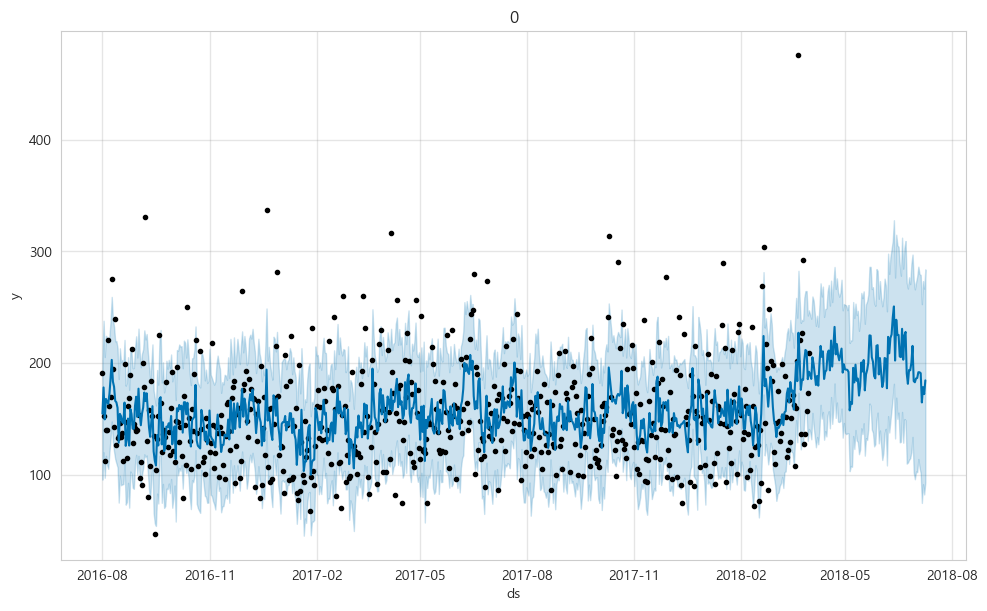

12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing


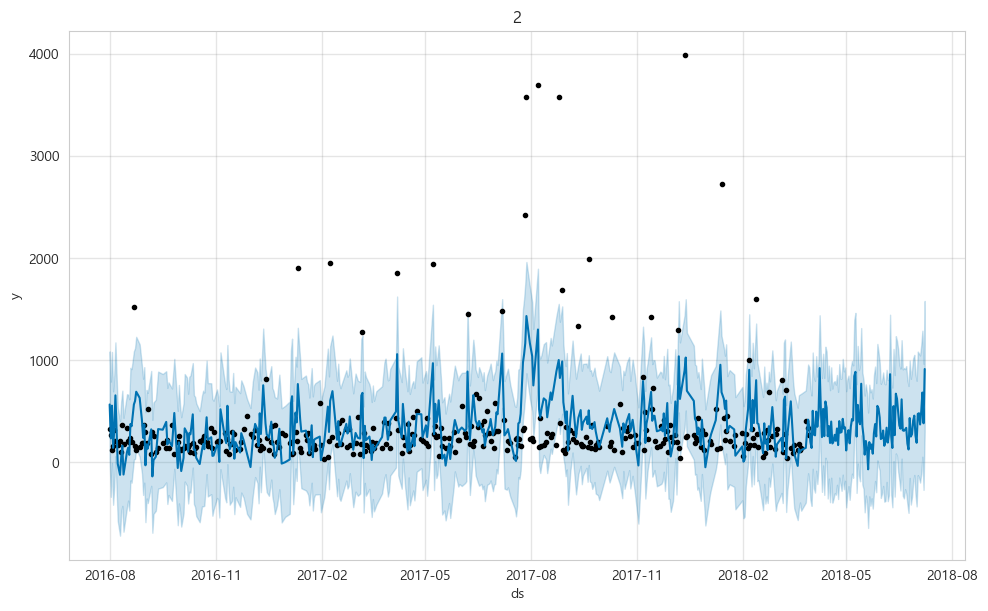

12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing


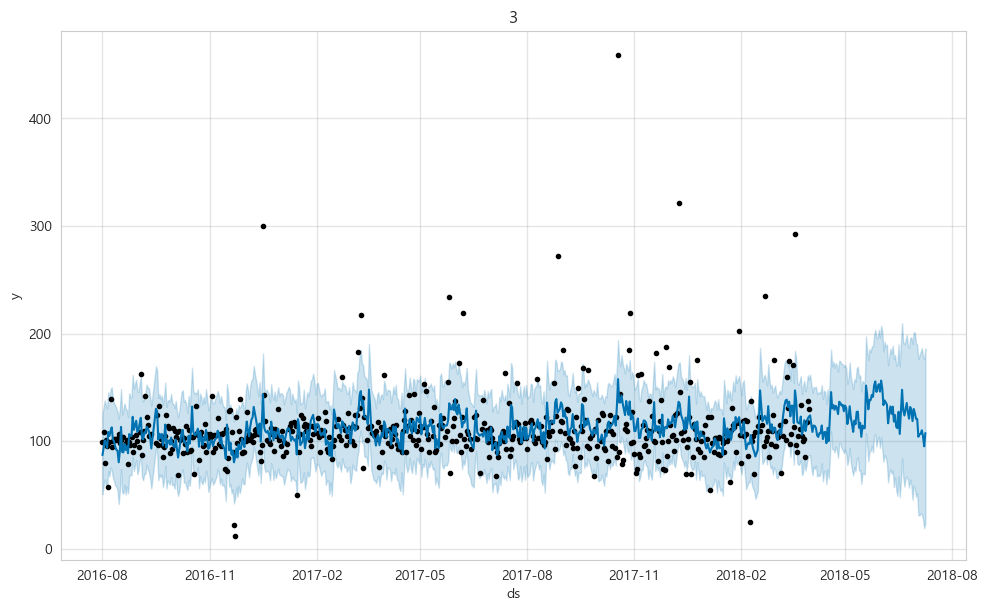

12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing


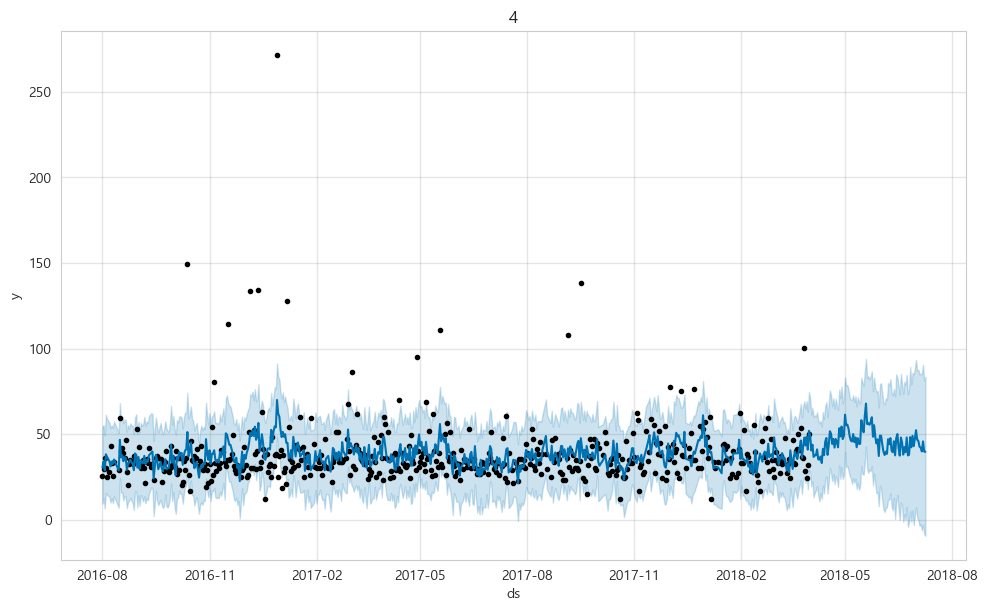

12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing


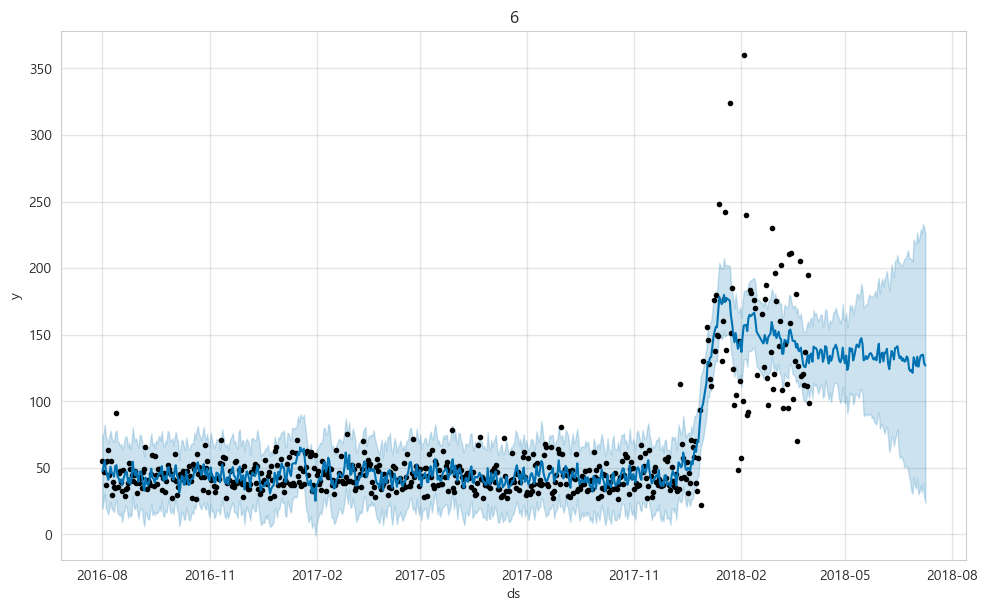

12:06:40 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing


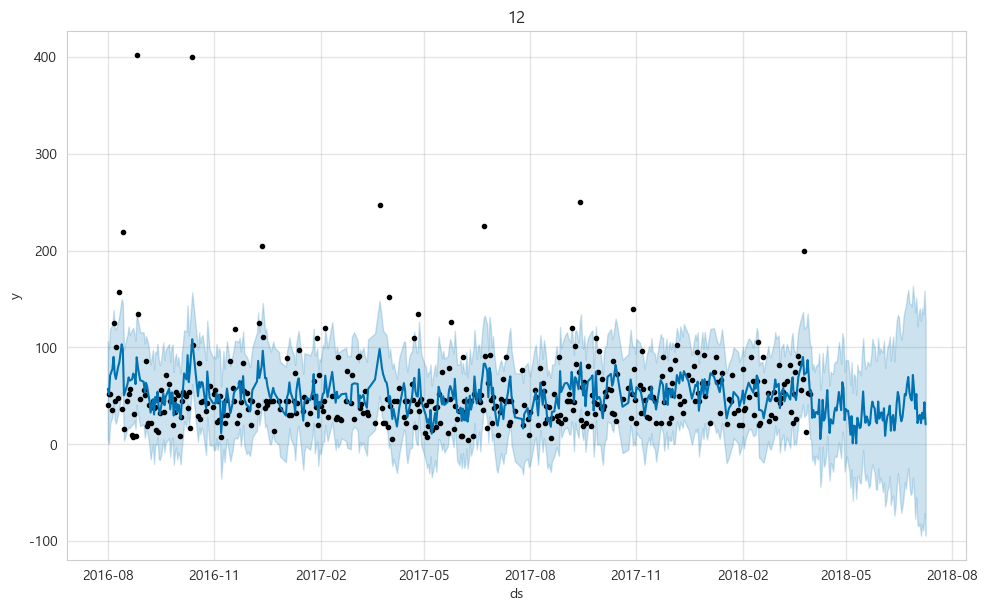

12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing


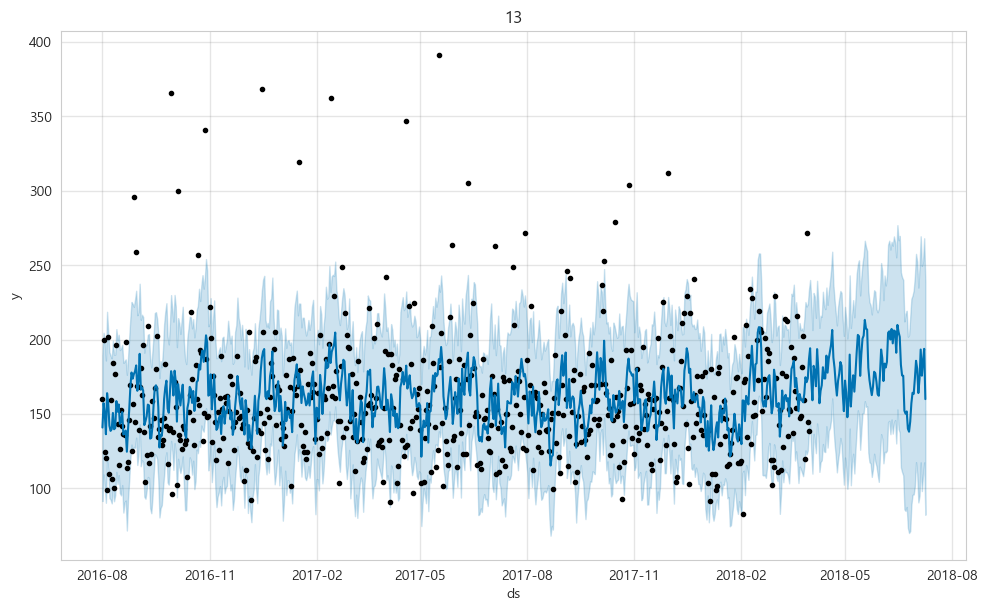

12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing


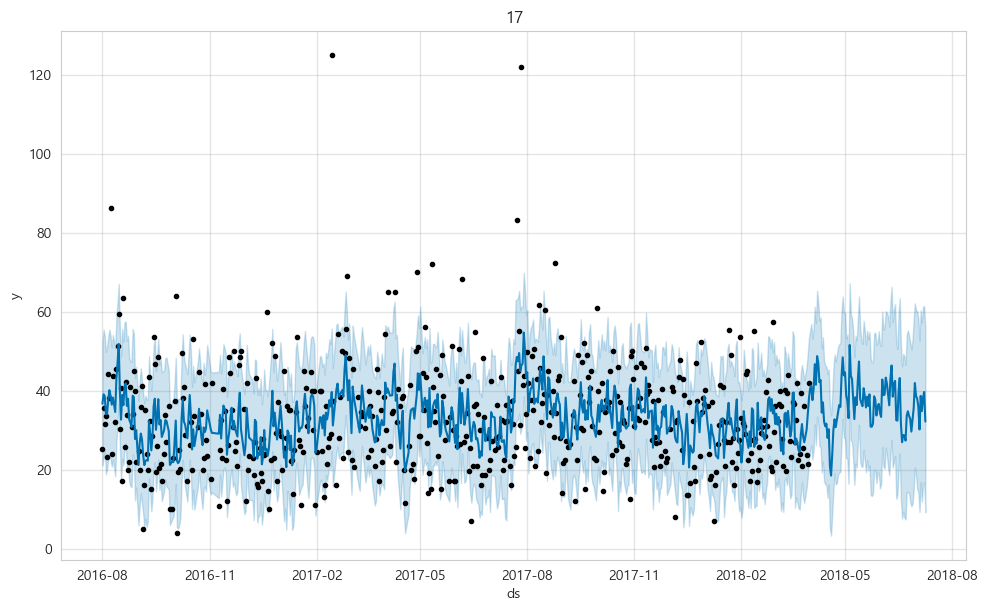

12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing


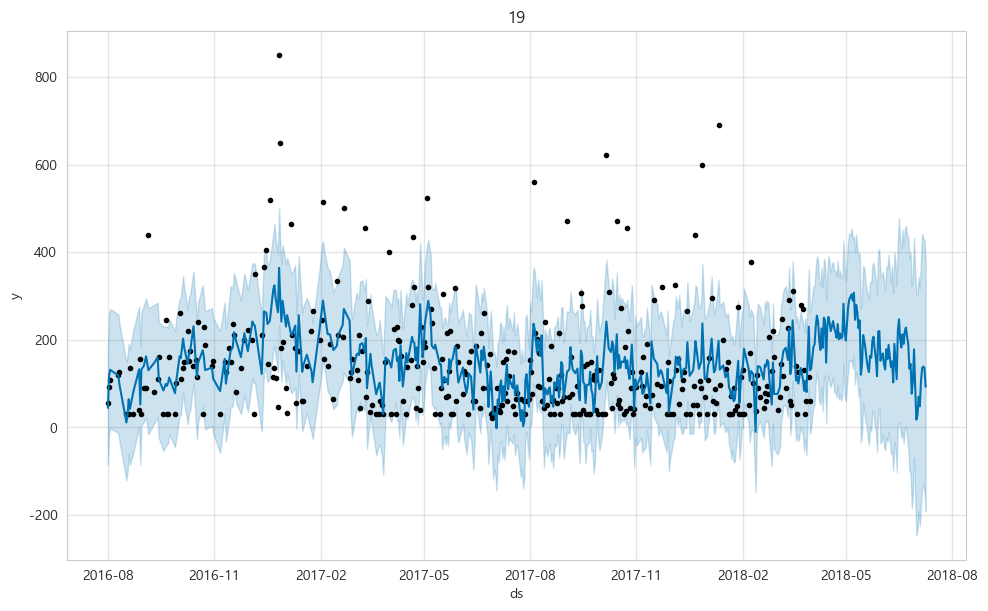

12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing


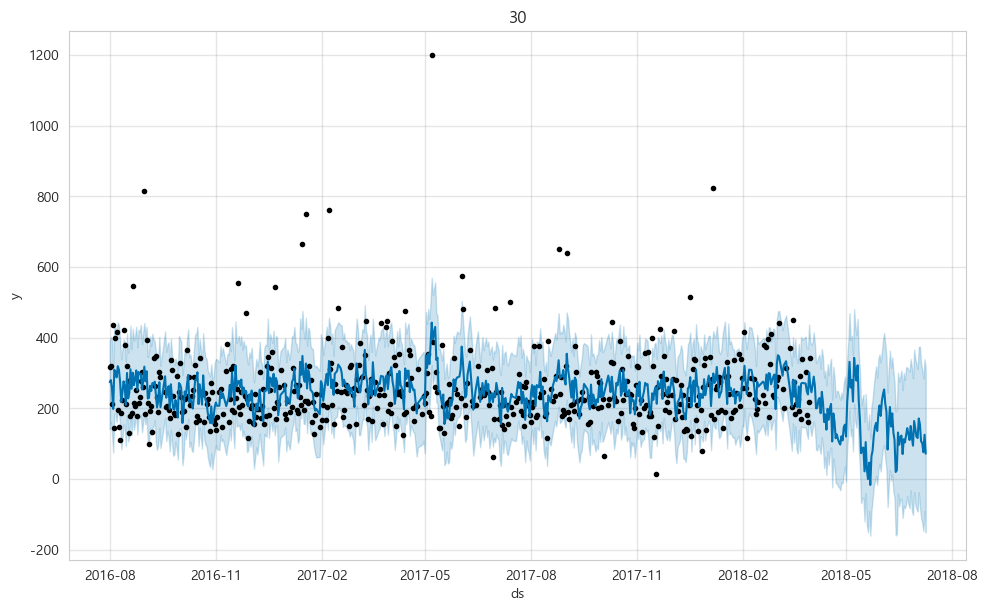

In [15]:
# 하루로 묶어서 진행
train_grouped = new_test.groupby(['date', 'store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
stored_ids = []
for i in train_grouped.store_id.unique()[:10]:
    sample = train_grouped[train_grouped.store_id == i]
    sample.drop('store_id', axis=1, inplace=True)

    if Train:
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index = sample['date']
        sample.columns = ['ds', 'y']

        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else:
        sample['date'] = pd.to_datetime(sample['date'])
        sample.columns = ['ds', 'y']
        test = sample
    # 예측
    m = Prophet(
        holidays=holidays,
        changepoint_prior_scale=10,
        changepoint_range=0.5
    )
    m.add_seasonality(name='daily', period=1, fourier_order=15)
    m.add_seasonality(name='weekly', period=7, fourier_order=20)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
    m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5, prior_scale=15)
    m.add_seasonality(name='yearly', period=365.25, fourier_order=20)
    m.fit(test)

    future = m.make_future_dataframe(periods=100)
    forecast = m.predict(future)
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)
    stored_ids.append(i)

    # 시각화 부분
    fig1 = m.plot(forecast)
    plt.title(i)
    plt.show()

In [23]:
# 전체 진행
train_grouped = new_test.groupby(['date', 'store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
stored_ids = []
for i in train_grouped.store_id.unique():
    sample = train_grouped[train_grouped.store_id == i]
    sample.drop('store_id', axis=1, inplace=True)

    if Train:
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index = sample['date']
        sample.columns = ['ds', 'y']

        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
    else:
        sample['date'] = pd.to_datetime(sample['date'])
        sample.columns = ['ds', 'y']
        test = sample
    # 예측
    m = Prophet(
        holidays=holidays,
        changepoint_prior_scale=10,
        changepoint_range=0.5
    )

    m.add_seasonality(name='daily', period=1, fourier_order=15)
    m.add_seasonality(name='weekly', period=7, fourier_order=20)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=12)
    m.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5, prior_scale=15)
    m.add_seasonality(name='yearly', period=365.25, fourier_order=20)
    m.fit(test)

    future = m.make_future_dataframe(periods=100)
    forecast = m.predict(future)
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)
    stored_ids.append(i)
    # 시각화
    # fig1 = m.plot(forecast)
    # plt.title(i)
    # plt.show()

11:32:01 - cmdstanpy - INFO - Chain [1] start processing
11:32:01 - cmdstanpy - INFO - Chain [1] done processing
11:32:01 - cmdstanpy - INFO - Chain [1] start processing
11:32:02 - cmdstanpy - INFO - Chain [1] done processing
11:32:02 - cmdstanpy - INFO - Chain [1] start processing
11:32:03 - cmdstanpy - INFO - Chain [1] done processing
11:32:03 - cmdstanpy - INFO - Chain [1] start processing
11:32:04 - cmdstanpy - INFO - Chain [1] done processing
11:32:04 - cmdstanpy - INFO - Chain [1] start processing
11:32:05 - cmdstanpy - INFO - Chain [1] done processing
11:32:05 - cmdstanpy - INFO - Chain [1] start processing
11:32:06 - cmdstanpy - INFO - Chain [1] done processing
11:32:06 - cmdstanpy - INFO - Chain [1] start processing
11:32:06 - cmdstanpy - INFO - Chain [1] done processing
11:32:07 - cmdstanpy - INFO - Chain [1] start processing
11:32:07 - cmdstanpy - INFO - Chain [1] done processing
11:32:07 - cmdstanpy - INFO - Chain [1] start processing
11:32:08 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [17]:
result = pd.DataFrame(data={'store_id': stored_ids, 'amount': y_pred}).sort_values('store_id')
result

,store_id,amount
0,0,15557.147004
1,2,15557.147004
2,3,15557.147004
3,4,15557.147004
4,6,15557.147004
5,12,15557.147004
6,13,15557.147004
7,17,15557.147004
8,19,15557.147004
9,30,15557.147004
